In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 600,
})

import numpy as np
import torch

rng = np.random.default_rng()

# Convert data

## Loading data from Apr 5, 2023

Block 3


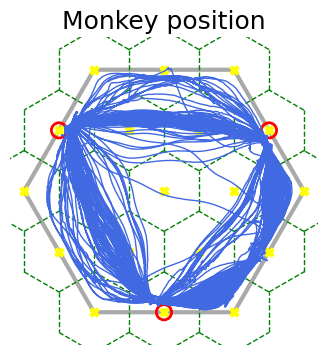

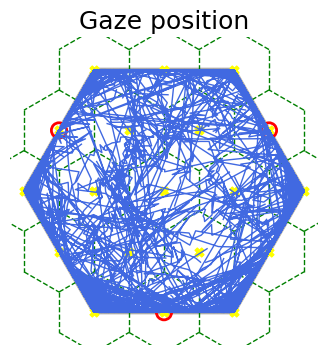

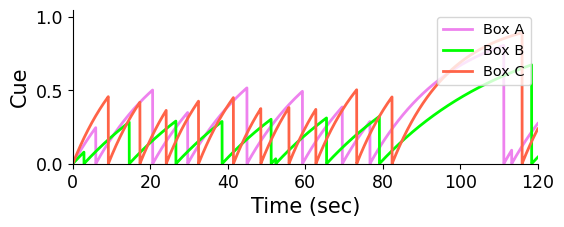

observations: (1206, 5)
actions: (1205,)


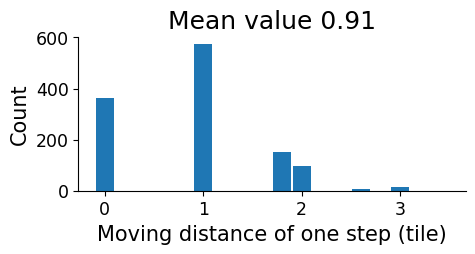

In [2]:
from hexarena.env import ForagingEnv
from hexarena.utils import load_monkey_data, discretize_monkey_data, extract_observation_action


env = ForagingEnv(arena={'resol': 2}, boxes=[{'num_grades': 10, 'num_patches': 1}]*3, dt=1)

filename = 'store/monkey-data_040523/testSession2.mat'
block_idx = rng.choice(7)
print('Block {}'.format(block_idx+1))
block_data = load_monkey_data(filename, block_idx)

_, ax = plt.subplots(figsize=(4, 4))
env.arena.plot_map(ax)
pos_xyz = block_data['pos_xyz']/1860.5
ax.plot(pos_xyz[:, 0], pos_xyz[:, 1], color='royalblue', linewidth=1)
ax.set_title('Monkey position')

_, ax = plt.subplots(figsize=(4, 4))
env.arena.plot_map(ax)
pos_xyz = block_data['gaze_xyz']/1860.5
ax.plot(pos_xyz[:, 0], pos_xyz[:, 1], color='royalblue', linewidth=1)
ax.set_title('Gaze position')

_, ax = plt.subplots(figsize=(6, 2))
colors = ['violet', 'lime', 'tomato']
for i, color in enumerate(colors):
    ax.plot(block_data['t'], block_data['cues'][:, i], color=color)
ax.legend(['Box A', 'Box B', 'Box C'], fontsize='x-small', loc='upper right')
ax.set_xlim([0, 120])
ax.set_xlabel('Time (sec)')
ax.set_ylim([0, 1.05])
ax.set_ylabel('Cue')

plt.show()

env_data = discretize_monkey_data(block_data, env)
observations, actions = extract_observation_action(env_data, env)
print('observations: {}'.format(observations.shape))
print('actions: {}'.format(actions.shape))

ds = []
for i in range(len(actions)):
    x1, y1 = env.arena.anchors[observations[i+1, 0]]
    x0, y0 = env.arena.anchors[observations[i, 0]]
    ds.append(((x1-x0)**2+(y1-y0)**2)**0.5)
ds = np.array(ds)*env.arena.resol

_, ax = plt.subplots(figsize=(5, 2))
ax.hist(ds, np.arange(-0.1, ds.max(), 0.2), rwidth=0.9)
ax.set_xlabel('Moving distance of one step (tile)')
ax.set_ylabel('Count')
ax.set_title('Mean value {:.2f}'.format(ds.mean()))

plt.show()

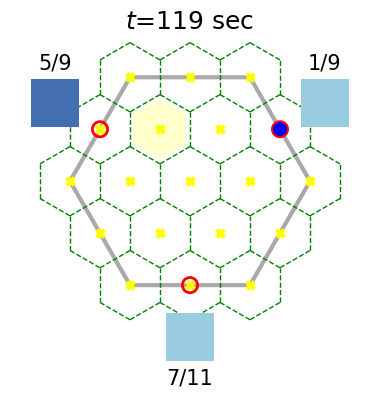

In [3]:
fig, ani = env.play_episode(
    env_data['pos'], env_data['gaze'], env_data['colors'],
    env_data['push'], env_data['success'], num_steps=120,
)
ani.save('store/monkey-trial_block-{:d}.gif'.format(block_idx+1))

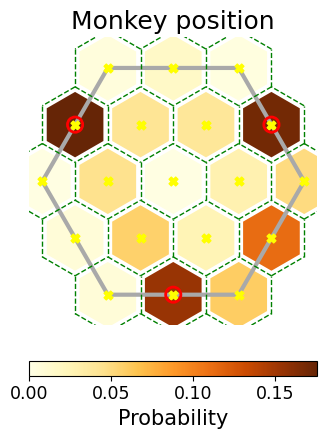

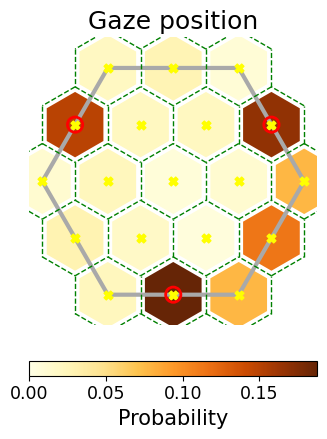

In [4]:
fig_p, fig_g = env.plot_occupancy(env_data['pos'], env_data['gaze'])

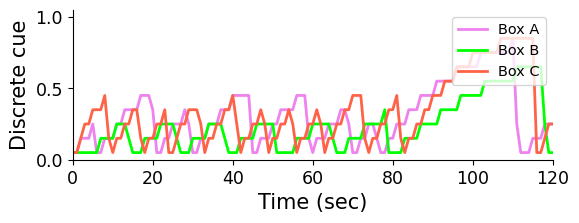

In [5]:
cues = env_data['colors'][..., 0, 0].astype(float)
for b_idx, box in enumerate(env.boxes):
    cues[:, b_idx] = (cues[:, b_idx]+0.5)/box.num_grades

fig, ani = env.play_traces(cues, num_steps=120, ylabel='Discrete cue')
ani.save('store/monkey-cue_block-{:d}.gif'.format(block_idx+1))